In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from pathlib import Path
import rerun as rr
from b3d.utils import keysplit


key = jax.random.PRNGKey(0)

In [3]:
from b3d.chisight.sfm.datasets import TumRgbdData


root = Path("/home/mirkoklukas/workspace/data/rgbd_slam_dataset_freiburg")
datasets = TumRgbdData._show_available_datasets(root)

Available datasets in /home/mirkoklukas/workspace/data/rgbd_slam_dataset_freiburg/...:
(0) rgbd_dataset_freiburg3_sitting_static
(1) rgbd_dataset_freiburg1_xyz
(2) rgbd_dataset_freiburg3_long_office_household


Sequence rgbd_dataset_freiburg3_long_office_household already exists.
Num Frames: 2585


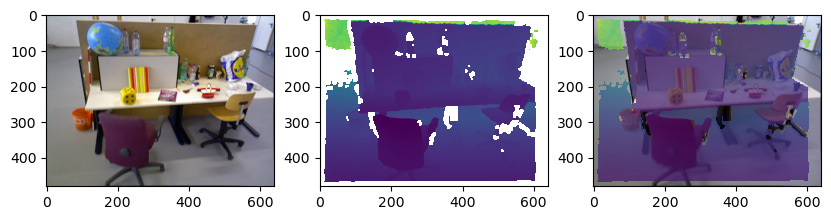

In [4]:
# sequence_name = datasets[0]
sequence_name = "rgbd_dataset_freiburg3_long_office_household"

# Download the sequence
sequence_url = TumRgbdData._sequence_url_from_sequence_name(sequence_name)
sequence_folder = TumRgbdData._download_from_url(sequence_url, root)
path = root/sequence_name
data = TumRgbdData(path)

# Get the i'th RGB image
# Note that rgb, depth, and pose sequences are not synchronized, so the i'th RGB image
# and the i'th depth image and pose are not guaranteed to be from the same time.
i = 100
rgb = data.get_rgb(i)

print(f"Num Frames: {len(data)}")

# This returns i'th RGB image and the CLOSEST (in time) available depth image and pose
rgb, depth, pose = data.get_synced(i)
# ==============================================
# Plot the RGB and depth images side by side
fig, axs = plt.subplots(1, 3, figsize=(10,5))
axs[0].imshow(rgb)
axs[1].imshow(np.where(depth>0, depth, np.nan))
axs[2].imshow(rgb, alpha=1.)
axs[2].imshow(np.where(depth>0, depth, np.nan), alpha=0.75);

In [5]:
from b3d.chisight.sfm.utils import (
    rescale_pose,
    rescale_poses,
    slicify,
    xq_dist,
    xq_cos,
    vals_from_im,
)
from b3d.chisight.sfm.plotting_utils import (
    log_pose,
)
from b3d.chisight.sfm.opencv_wrapper import (
    infer_pose,
    infer_pose_and_inlier,
    detect_and_match_sift,
)
from b3d.chisight.sfm.eight_point import (
    epipolar_residual_errors,
    epipolar_errors,
    poses_from_essential,
    essential_from_pose,
    triangulate_linear_hartley,
)
from b3d.pose import Pose

from b3d.camera import (
    Intrinsics, 
    camera_matrix_from_intrinsics, 
    camera_from_screen, 
    screen_from_camera,
    screen_from_world,
    camera_from_screen_and_depth,
)


intr  = Intrinsics.from_array(data.get_intrinsics())
cam_K = camera_matrix_from_intrinsics(intr)
cam_K_inv = jnp.linalg.inv(cam_K)

In [6]:
@jax.jit
def jit_screen_from_world(xs, p, intr):
    return screen_from_world(xs, p, intr)

def rgb_to_gray(rgb):
    v = jnp.array([0.2125, 0.7154, 0.0721 ])
    return jnp.array(jnp.dot(rgb[...,:3], v))


      Pos  diff   0.10, 
      Quat diff   0.05



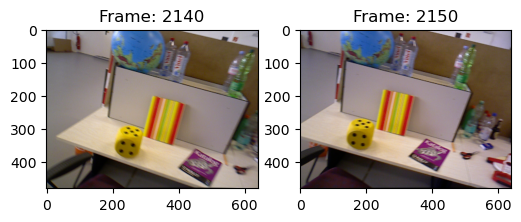

In [431]:
t0 = [2140, 1700, 1500, 1200, 600, 150, 40, 350][0] 
dt = 10
t1 = t0 + dt
t2 = t1 + dt


rgb, depth, cams = data[[t0,t1]]
p_true = cams[0].inv() @ cams[1]
rgb = jnp.array(rgb)
gray = rgb_to_gray(rgb)/255

# ==============================================
print(f"""
      Pos  diff  {xq_dist(cams[0], cams[1])[0]:>5.2f}, 
      Quat diff  {xq_dist(cams[0], cams[1])[1]:>5.2f}
""")
data.plot_multiple_frames([t0,t1], axs=None);

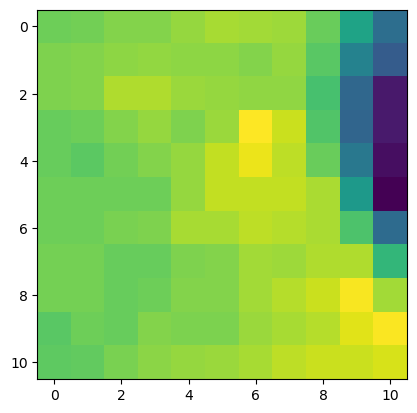

In [432]:
def get_patch(u, im, w=5):
    u = u.astype(int)
    if len(im.shape) == 3:
        patch = jax.lax.dynamic_slice(im, (u[1]-w, u[0]-w, 0), (2*w + 1, 2*w + 1, im.shape[2]))
    else:
        patch = jax.lax.dynamic_slice(im, (u[1]-w, u[0]-w), (2*w + 1, 2*w + 1))

    return patch


plt.imshow(get_patch(jnp.array([250,350]), rgb[0], w=5))
plt.imshow(get_patch(jnp.array([250,350]), rgb_to_gray(rgb[0]), w=5))

In [433]:
w = rgb.shape[2]
h = rgb.shape[1]
us = jnp.stack(jnp.meshgrid(jnp.arange(0, w), jnp.arange(0, h),  indexing='xy'), axis=-1)
us.shape

(480, 640, 2)

In [434]:
def _brief(I, locs):
    I0 = I[locs[0,:,1], locs[0,:,0]]
    I1 = I[locs[1,:,1], locs[1,:,0]]
    return I0 < I1


def _brief2(u, im, locs, w=5):
    I = get_patch(u, im, w=w)
    I0 = I[locs[0,:,1], locs[0,:,0]]
    I1 = I[locs[1,:,1], locs[1,:,0]]
    return (I0 < I1).astype(int)


w = 5
u = jnp.array([250,350])
patch = get_patch(u, rgb[0], w=w)
patch = rgb_to_gray(patch)

locs = jax.random.uniform(key, (2, 256, 2), minval=0, maxval=w-1).astype(int)

patches = jax.vmap(get_patch, (0, None, None))(us.reshape(-1,2), rgb_to_gray(rgb[0]), 5)
bs = jax.vmap(_brief, (0, None))(patches, locs)


patches1 = jax.vmap(get_patch, (0, None, None))(us.reshape(-1,2), rgb_to_gray(rgb[1]), 5)
bs1 = jax.vmap(_brief, (0, None))(patches1, locs)

In [435]:
import numpy as np
import cv2

def gaussian_pyramid(image, levels):
    image = np.array(image)
    pyramid = [image]
    for i in range(1, levels):
        # Apply Gaussian blur
        image = cv2.GaussianBlur(image, (5, 5), sigmaX=1.0)
        # Downsample the image by taking every second pixel in each dimension
        image = image[::2, ::2]
        pyramid.append(image)


    return pyramid



gaussian_pyramid(np.array(rgb[0]), 4)[1].shape

(240, 320, 3)

In [436]:
def blur_downsample(image, sigma=1.0):
    image = np.array(image)
    image = cv2.GaussianBlur(image, (5, 5), sigmaX=sigma)
    image = image[::2, ::2]
    return image

In [437]:


w = 5

key = keysplit(key)
# u = jnp.array([250,350])
u = jax.random.uniform(key, (2,), minval=jnp.array([0,0]), maxval=jnp.array([rgb.shape[2]-1,rgb.shape[1]-1])).astype(int)


key = keysplit(key)
locs = jax.random.uniform(key, (2, 256, 2), minval=0, maxval=w-1).astype(int)

key, keys = keysplit(key, 1, 2)
locs = jnp.stack([
    jax.random.normal(keys[0], (256, 2)),
    w/2*jax.random.normal(keys[1], (256, 2)),
], axis=0)


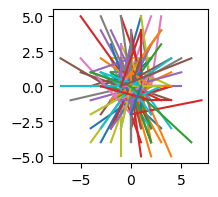

In [438]:
locs = locs.astype(int)

plt.figure(figsize=(2,2))
plt.plot(locs[:,:,0], locs[:,:,1]);

In [439]:
def _brief2(u, im, locs, w=5):
    I = get_patch(u, im, w=w)
    I0 = I[locs[0,:,1], locs[0,:,0]]
    I1 = I[locs[1,:,1], locs[1,:,0]]
    # return (I0 < I1).astype(int)
    return I0 - I1


locs = locs.astype(int)

b0 = _brief2(u, rgb_to_gray(rgb[0]), locs, w)
b1s = jax.vmap(_brief2, (0, None, None, None))(us.reshape(-1,2), rgb_to_gray(rgb[0]), locs, w)



jbrief = jax.jit(jax.vmap(_brief2, (0, None, None, None)), static_argnames=("w",))

(60, 80)
(4800, 2)
171 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


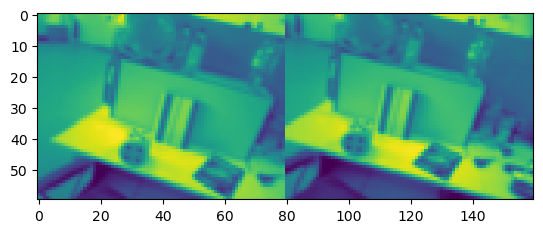

In [760]:
gray0 = rgb_to_gray(rgb[0])
gray1 = rgb_to_gray(rgb[1])

gray0 = blur_downsample(gray0, sigma=1.0)
gray1 = blur_downsample(gray1, sigma=1.0)
gray0 = blur_downsample(gray0, sigma=1.0)
gray1 = blur_downsample(gray1, sigma=1.0)
gray0 = blur_downsample(gray0, sigma=1.0)
gray1 = blur_downsample(gray1, sigma=1.0)
gray0 = jnp.array(gray0)
gray1 = jnp.array(gray1)

print(gray0.shape)

us = jnp.stack(jnp.meshgrid(jnp.arange(0, gray0.shape[1]), jnp.arange(0, gray0.shape[0]),  indexing='xy'), axis=-1)
uu = us.reshape(-1,2)

print(uu.shape)

w = 5
key, keys = keysplit(key, 1, 2)
locs = jnp.stack([
    jax.random.normal(keys[0], (256, 2)),
    w/2*jax.random.normal(keys[1], (256, 2)),
], axis=0)
locs = locs.astype(int)


%timeit -n 1 -r 1 jax.block_until_ready(jbrief(uu, gray0, locs, w))



plt.imshow(jnp.concatenate([gray0, gray1], axis=1))

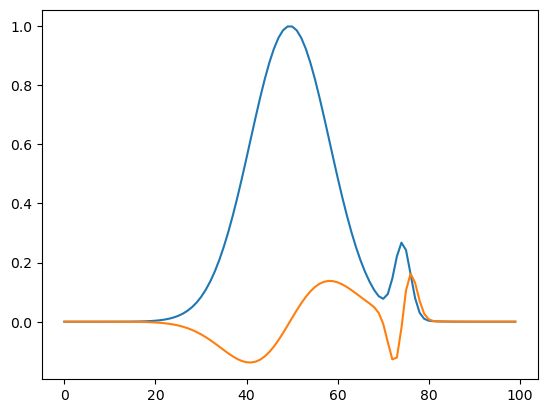

In [751]:


xs  = jnp.exp( -(0. - jnp.linspace(-2, 2.,100))**2/0.5**2)
xs += 0.25*jnp.exp( -(1. - jnp.linspace(-2, 2.,100))**2/0.1**2)
plt.plot(xs)

plt.plot(jax.scipy.signal.convolve(xs, jnp.array([-1,0,1]), mode="same"))

-2.6495018 2.1107914
-2.8669465 3.047515


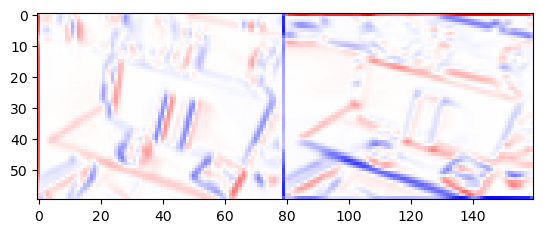

In [752]:
def im_gradient(I):
    kx = jnp.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1],
    ])
    ky = jnp.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1],
    ])
    Ix = jax.scipy.signal.convolve2d(I, -kx, mode="same")
    Iy = jax.scipy.signal.convolve2d(I, -ky, mode="same")

    return Ix, Iy

I = gray0/255


Ix,Iy = im_gradient(I)

print(Ix.min(), Ix.max())
print(Iy.min(), Iy.max())
plt.imshow(I)
plt.imshow(jnp.concatenate([Ix, Iy], axis=1), cmap="bwr", vmin=-3, vmax=3)

(60, 80)
(60, 80, 2)
(4800, 3, 3)


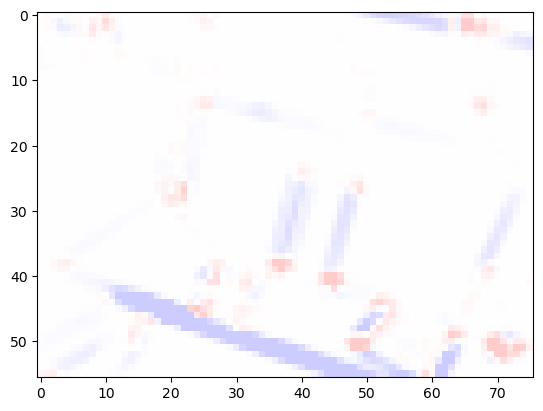

In [846]:
def lambdas(Ix, Iy):
    a = (Ix**2).sum()
    b = 2*(Ix*Iy).sum()
    c = (Iy**2).sum()

    l1 = 0.5*(a + c + jnp.sqrt(b**2 + (a-c)**2))
    l2 = 0.5*(a + c - jnp.sqrt(b**2 + (a-c)**2))
    return jnp.array([l1, l2])

def corner_response(ls, k=0.04):
    # k in [0.04, 0.06]
    return ls[...,0]*ls[...,1] - k*(ls[...,0] + ls[...,1])**2


I = gray0/255


Ix,Iy = im_gradient(I)

print(Ix.shape)
print(us.shape)

w = 1
Ix_ = jax.vmap(get_patch, (0, None, None))(us.reshape(-1,2), Ix, w)
Iy_ = jax.vmap(get_patch, (0, None, None))(us.reshape(-1,2), Iy, w)

print(Ix_.shape)
    

ls = jax.vmap(lambdas, (0, 0))(Ix_, Iy_)
ls = ls.reshape(Ix.shape + (2,))
# rs = corner_response(ls[w+1:-w-1,w+1:-w-1], k=0.04)
rs = corner_response(ls, k=0.06)


# valid = 

# plt.imshow(jnp.absolute(ls[...,0] - ls[...,1]))
# plt.imshow(I[w+1:-w-1,w+1:-w-1], cmap="gray")
plt.imshow(rs[w+1:-w-1,w+1:-w-1], alpha=0.2, cmap="bwr", vmin=-10., vmax=10.)

# plt.hist(rs.ravel(), bins=jnp.linspace(-0.1, 0.1, 100));

In [758]:
def a_func(Ix):
    return (Ix**2).sum()

In [577]:
def _brief(u, im, locs, w=5):
    I = get_patch(u, im, w=w)
    I0 = I[locs[0,:,1], locs[0,:,0]]
    I1 = I[locs[1,:,1], locs[1,:,0]]
    return (I0 < I1).astype(int)

def _brief2(u, im, locs, w=5):
    I = get_patch(u, im, w=w)
    I0 = I[locs[0,:,1], locs[0,:,0]]
    I1 = I[locs[1,:,1], locs[1,:,0]]
    return I0 - I1

jbrief  = jax.jit(jax.vmap(_brief,  (0, None, None, None)), static_argnames=("w",))
jbrief2 = jax.jit(jax.vmap(_brief2, (0, None, None, None)), static_argnames=("w",))

In [578]:
key = keysplit(key)
locs = jax.random.uniform(key, (2, 256, 2), minval=0, maxval=w-1).astype(int)

In [692]:
key = keysplit(key)
u = jax.random.uniform(key, (2,), minval=jnp.array([0,0]), maxval=jnp.array([gray0.shape[1]-1,gray0.shape[0]-1])).astype(int)

w = 5
b0  = _brief(u, gray0, locs, w)
b0_ = _brief2(u, gray0, locs, w)
b1s = jbrief(uu, gray1, locs, w)
b1s_ = jbrief2(uu, gray1, locs, w)

In [697]:
patches = jax.vmap(get_patch, (0, None, None))(us.reshape(-1,2), gray0, 5)
patches.shape

vs = patches.var(axis=(1,2)) 

mask = vs > jnp.quantile(vs, 0.5)
mask = vs > 0.0
mask.sum()

key = keysplit(key)
u = jax.random.choice(key, uu[mask])



w = 6
b0  = _brief(u, gray0, locs, w)
b0_ = _brief2(u, gray0, locs, w)
b1s = jbrief(uu, gray1, locs, w)
b1s_ = jbrief2(uu, gray1, locs, w)

0.91393125 0.10025888
1627.5352 209.07053


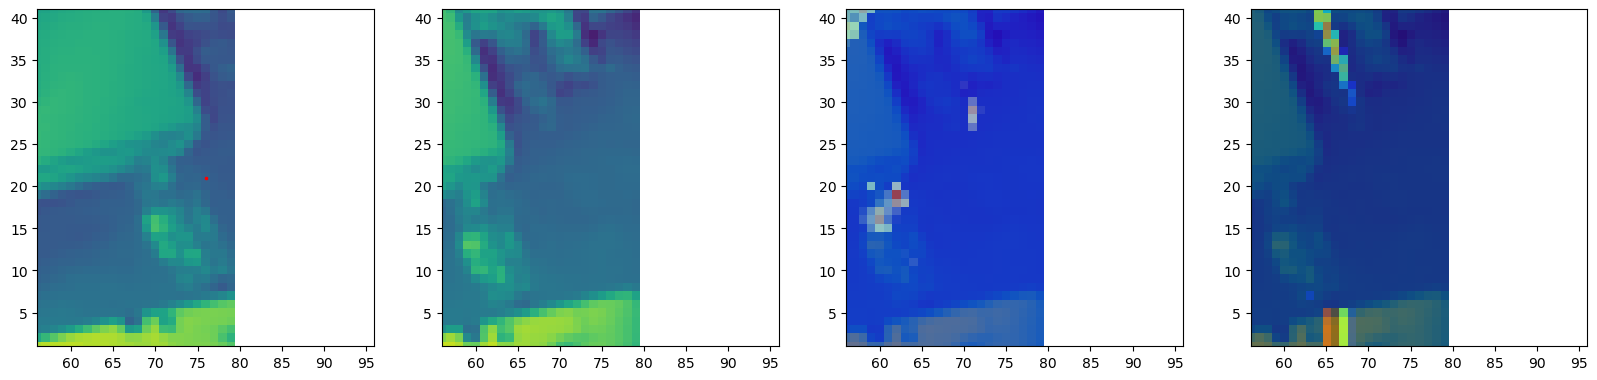

In [698]:
ss = jnp.linalg.norm(b1s - b0, axis=-1)
ss = jnp.exp(-ss**2/10.**2)
ss_ = jnp.linalg.norm(b1s_ - b0_, axis=-1)
# ss_ = jnp.exp(-ss_**2/1.**2)


print(ss.max(), ss.min())
print(ss_.max(), ss_.min())

im0 = gray0
im1 = gray1

fig, axs = plt.subplots(1,4, figsize=(20,10))


delta = 20
axs[0].set_xlim(u[0] - delta, u[0] + delta)
axs[0].set_ylim(u[1] - delta, u[1] + delta)

axs[0].imshow(im0)
axs[0].scatter(u[0], u[1], c='r', s=3, marker='x')

axs[1].set_xlim(u[0] - delta, u[0] + delta)
axs[1].set_ylim(u[1] - delta, u[1] + delta)

axs[1].imshow(im1)

axs[2].set_xlim(u[0] - delta, u[0] + delta)
axs[2].set_ylim(u[1] - delta, u[1] + delta)
axs[2].imshow(im1)
axs[2].imshow(ss.reshape(us.shape[:2]), cmap="bwr", alpha=.5, vmin=np.quantile(ss, 0.95))


axs[3].set_xlim(u[0] - delta, u[0] + delta)
axs[3].set_ylim(u[1] - delta, u[1] + delta)
axs[3].imshow(im1)
axs[3].imshow(ss_.reshape(us.shape[:2]), cmap="jet", alpha=.5, vmin=np.quantile(ss_, 0.95))


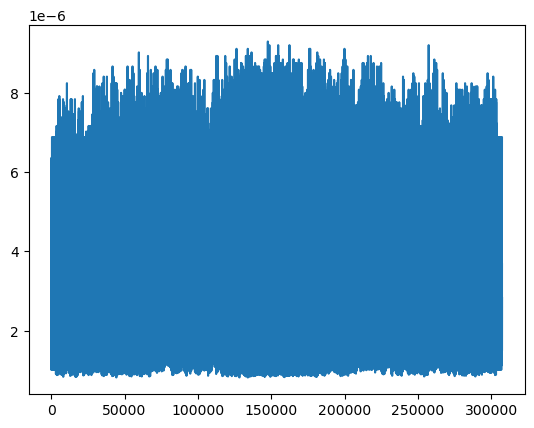

In [332]:
plt.plot(ss/ss.sum())

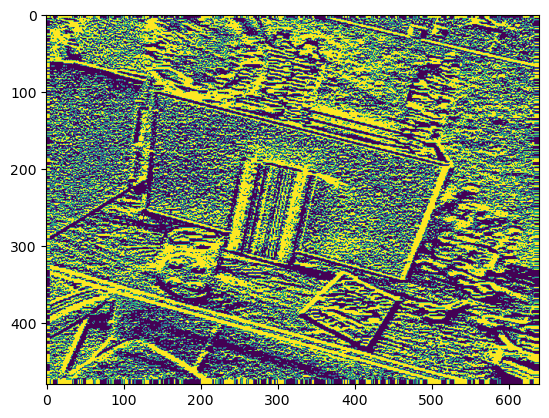

In [303]:
plt.imshow(bs1.reshape(us.shape[:2] +(bs1.shape[-1],))[:,:,1])

In [245]:
(uvs0_all, fs0, inds0), (uvs1_all, fs1, inds1) = detect_and_match_sift(rgb[0], rgb[1])
uvs0 = uvs0_all[inds0]
uvs1 = uvs1_all[inds1]
ys0 = camera_from_screen(uvs0, intr)
ys1 = camera_from_screen(uvs1, intr)


p, inlier = infer_pose_and_inlier(uvs0, uvs1, cam_K, prob=.999999, threshold=1.0, max_iters=1000)
p = rescale_pose(p, p_true)

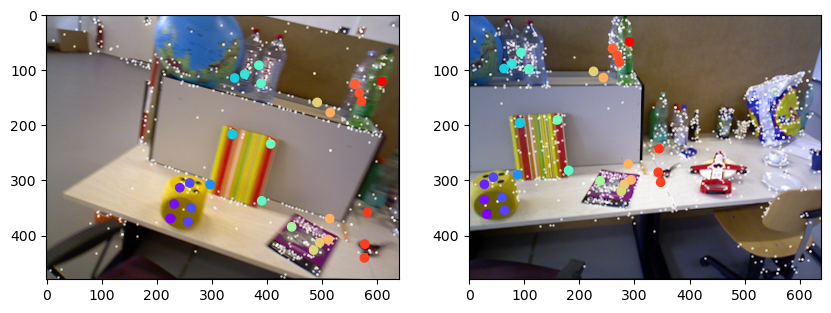

In [246]:
# ==============================================
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
ax.imshow(rgb[0])
ax.scatter(uvs0_all[:,0] , uvs0_all[:,1], c="w", s=1, alpha=0.5)
# ax.scatter(uvs0[:,0] , uvs0[:,1], c=uvs0[:, 0], cmap="rainbow")
ax.scatter(uvs0[inlier,0] , uvs0[inlier,1], c=uvs0[inlier, 0], cmap="rainbow")
ax = axs[1]

ax.imshow(rgb[1])
ax.scatter(uvs1_all[:,0] , uvs1_all[:,1], c="w", s=1, alpha=0.5)
# ax.scatter(uvs1[:,0] , uvs1[:,1], c=uvs0[:, 0], cmap="rainbow")
ax.scatter(uvs1[inlier,0] , uvs1[inlier,1], c=uvs0[inlier, 0], cmap="rainbow")

In [247]:
xs_tri = triangulate_linear_hartley(Pose.id(), p, ys0[inlier], ys1[inlier])
xs = jax.random.uniform(key, (10_000, 3), minval=-1.5, maxval=1.5) + xs_tri.mean(0) + jnp.array([0,0,0.5])

xs_true, cs_true, _ = data._get_colored_world_points(t0)

# =============
rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)
rr.log(f"True", rr.Points3D(xs_true, colors=cs_true, radii=.005))
rr.log(f"Triangulated", rr.Points3D(cams[0](xs_tri), colors=[1.,0.,0.], radii=.02))
rr.log(f"Test_points", rr.Points3D(cams[0](xs), colors=[0.,1.,0.], radii=.02))
log_pose("Pose[0]", cams[0], scale=0.5)
log_pose("Pose[1]", cams[0]@p, scale=0.5)

In [248]:
def _f(x, p, intr, w=5):
    u0 = screen_from_world(x, Pose.id(), intr).astype(int)
    u1 = screen_from_world(x, p, intr).astype(int)

    patch0 = jax.lax.dynamic_slice(gray[0], (u0[1]-w, u0[0]-w), (2*w + 1,2*w + 1))
    patch1 = jax.lax.dynamic_slice(gray[1], (u1[1]-w, u1[0]-w), (2*w + 1,2*w + 1))


    # patch0 = jax.lax.dynamic_slice(rgb[0]/255, (u0[1]-w, u0[0]-w,0), (2*w + 1,2*w + 1,3))
    # patch1 = jax.lax.dynamic_slice(rgb[1]/255, (u1[1]-w, u1[0]-w,0), (2*w + 1,2*w + 1,3))

    patch0_ = patch0 - patch0.mean()
    patch1_ = patch1 - patch1.mean()
    return (patch0_*patch1_).sum() / jnp.sqrt( (patch0_**2).sum() * (patch1_**2).sum() ), patch0.var()
    # 
    # return jnp.linalg.norm(patch0 - patch1, axis=-1).mean(),  patch0.var(0).mean()


f = jax.jit(jax.vmap(_f, (0, None, None, None)), static_argnames=("w",))

In [249]:

def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def in_sight(xs, p, intr):
    us = screen_from_world(xs, p, intr)
    return jnp.logical_and(
        jnp.logical_and(us[:,0] >= 0, us[:,0] <= intr.width),
        jnp.logical_and(us[:,1] >= 0, us[:,1] <= intr.height)
    )

In [250]:
# px_ = jnp.stack(jnp.meshgrid(jnp.arange(intr.width), jnp.arange(intr.height)), axis=-1)
# px = px_.reshape(-1, 2)


# zs = jnp.linspace(1., 3., 20)

# xs = jax.vmap(camera_from_screen_and_depth, (0,None,None))(px, zs, intr)
# xs = xs.reshape(-1,3)

# print(xs.shape)

# rr.log(f"Test_points", rr.Points3D(cams[0](xs), colors=[1.,0.,0.], radii=.02))


In [251]:
xs_tri = triangulate_linear_hartley(Pose.id(), p, ys0[inlier], ys1[inlier])
xs = jax.random.uniform(key, (5_000_000, 3), minval=-1.5, maxval=1.5) + xs_tri.mean(0) + jnp.array([0,0,0.5])
xs = xs[in_sight(xs, Pose.id(), intr)*in_sight(xs, p, intr)]

u0 = jit_screen_from_world(xs, Pose.id(), intr)
u1 = screen_from_world(xs, p, intr)


c0 = vals_from_im(u0, jnp.array(rgb[0]))
c1 = vals_from_im(u1, jnp.array(rgb[1]))

c0.shape

(1886275, 3)

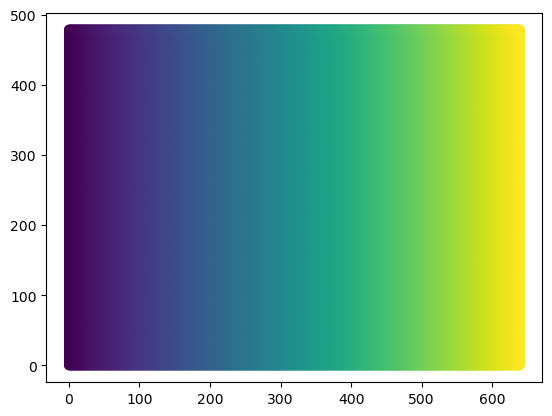

: 

In [231]:
zs = jnp.linspace(1., 3., 1_00)
us = jnp.stack(jnp.mgrid[:640, :480]).T

plt.scatter(*us.reshape(-1,2).T, c=us.reshape(-1,2)[:,0])
# us.shape

In [255]:

p = p_true


zs = jnp.linspace(1., 3., 2_00)
us = jnp.stack(jnp.mgrid[:640, :480]).T
print(us.shape)

xs = camera_from_screen_and_depth(us[:,:,None], zs[None,None], intr)

shape = xs.shape
xs = xs.reshape(-1,3)

u0 = jit_screen_from_world(xs, Pose.id(), intr)
u1 = screen_from_world(xs, p, intr)


c0 = vals_from_im(u0, jnp.array(rgb[0]))
c1 = vals_from_im(u1, jnp.array(rgb[1]))


vs, vars = f(xs, p_true, intr, 5)
inf_mask = jnp.isinf(vs)==False
nan_mask = jnp.isnan(vs)==False
inf_mask = inf_mask*nan_mask

vs = vs.reshape(shape[:-1])

vs = jnp.nan_to_num(vs, -10.0)

perm = jnp.argsort(vs, axis=-1)

# vs = vs[jnp.arange(vs.shape[0]), jnp.arange(vs.shape[1]), perm]
print("perm", perm.shape)
# vs = vs[*jnp.mgrid[:480, :640], perm]

ii = jnp.stack(jnp.mgrid[:640, :480]).T
# ii = jnp.stack(jnp.mgrid[:480, :640]).T

# vs[ii[:,:,[0]], ii[:,:,[1]], perm[:,:,-20:]]

0
xs = xs.reshape(shape)[ii[:,:,[1]], ii[:,:,[0]], perm[:,:,-20:]]

xs = xs[::10, ::10]



cs = vals_from_im(jit_screen_from_world(xs.reshape(-1,3), Pose.id(), intr), jnp.array(rgb[0]))



rr.log(f"Test_points_new", rr.Points3D(cams[0](xs.reshape(-1,3)), colors=cs, radii=.01))
# rr.log(f"Test_points_new", rr.Points3D(cams[0](xs.reshape(-1,3)), colors=c0.reshape(-1,3), radii=.01))

(480, 640, 2)
perm (480, 640, 200)


1.52 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
-1.0000001 1.0
27554


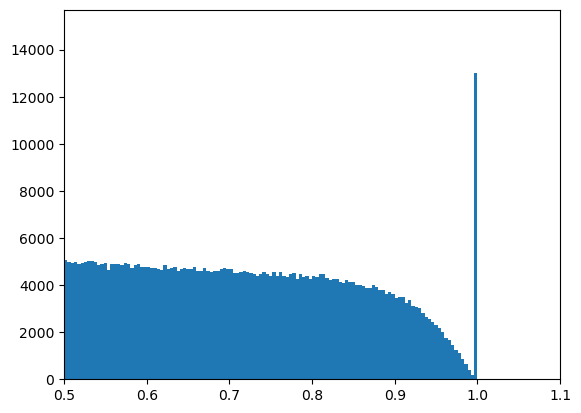

In [54]:

# xs = cams[0].inv()(xs_true)

# p = cams[0].inv()@cams[1]
u0 = jit_screen_from_world(xs, Pose.id(), intr)
u1 = screen_from_world(xs, p, intr)






%timeit -n 1 -r 1 jax.block_until_ready(jit_screen_from_world(xs, Pose.id(), intr));
%timeit -n 1 -r 1 jax.block_until_ready(f(xs, p, intr, 10));


c0 = vals_from_im(u0, jnp.array(rgb[0]))
c1 = vals_from_im(u1, jnp.array(rgb[1]))







vs, vars = f(xs, p_true, intr, 3)

inf_mask = jnp.isinf(vs)==False
nan_mask = jnp.isnan(vs)==False
inf_mask = inf_mask*nan_mask
print(vs[inf_mask].min(), vs[inf_mask].max())


# plt.ylim(0,100)
plt.xlim(0.5, 1.1)

plt.hist(vs[inf_mask], bins=500)

# mask = vs > .9
mask = vs > .95
# mask = (vs > 0.5) * (vs < 0.6) 

# mask = mask*inf_mask*(vars > 1.*1e-6)
mask = mask*inf_mask
print(mask.sum())



rr.log(f"Test_points", rr.Points3D(cams[0](xs[mask]), colors=c0[mask], radii=.01))
rr.log(f"Test_points_2", rr.Points3D(cams[0](xs[mask]), colors=colormaps["viridis"](normalize(vars[mask])), radii=.011))

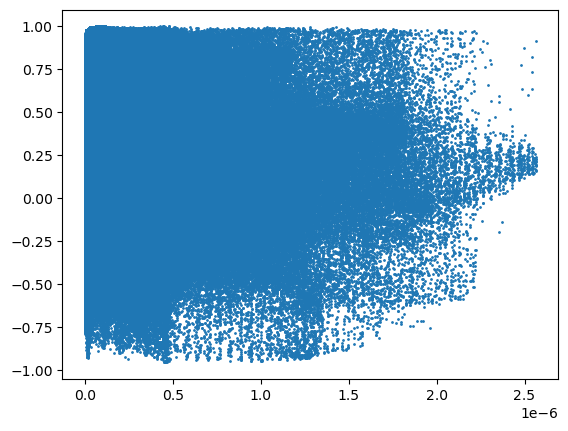

In [343]:
plt.scatter(vars, vs, s=1)

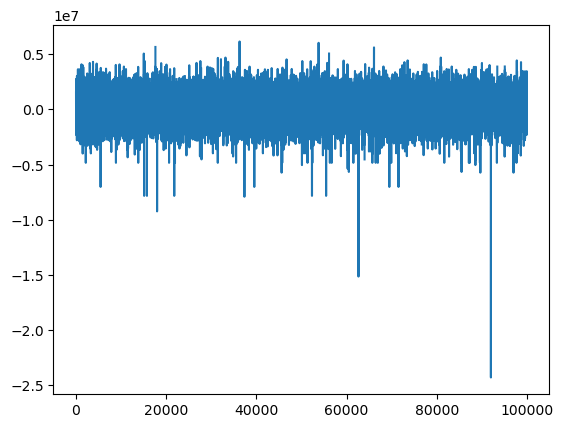

In [165]:
plt.plot(vs[inf_mask])

In [667]:
def func(t0, t1):
    rgb, depth, cams = data[[t0,t1]]
    (uvs0_all, fs0, inds0), (uvs1_all, fs1, inds1) = detect_and_match_sift_cv(rgb[0], rgb[1])
    uvs0 = uvs0_all[inds0]
    uvs1 = uvs1_all[inds1]
    p_cv, inlier_cv = infer_pose_and_inlier_cv(uvs0, uvs1, cam_K, prob=.9999, threshold=1.0, max_iters=1000)
    return {
        "rgb": rgb, 
        "depth": depth, 
        "cams": cams, 
        "inferred_pose": p_cv,
        "uvs0": uvs0,
        "uvs1": uvs1,
        "inlier": inlier_cv,
        "uvs0_all": uvs0_all,
        "uvs1_all": uvs1_all,
        "inds0": inds0,
        "inds1": inds1,
        }



dt = 40
# 2140
ts = [2140 + i*dt for i in range(3)]
objs = []
for (t0,t1) in zip(ts[:-1], ts[1:]):
    print(t0,t1)
    objs.append(func(t0, t1))

ps = [Pose.id()]
for p in [o["inferred_pose"] for o in objs]: 
    print(p)
    ps.append(ps[-1] @ p)
ps = Pose.stack_poses(ps)


cams = [objs[0]["cams"][0]]
for p in [o["cams"][1] for o in objs]: 
    cams.append(p)
cams = Pose.stack_poses(cams)

2140 2180
2180 2220
Pose(position=Array([ 0.17078036,  0.19642425, -0.96553165], dtype=float32), quaternion=Array([ 0.04088708, -0.19120288, -0.1727764 , -0.965359  ], dtype=float32))
Pose(position=Array([-0.19521505,  0.25438496, -0.9471957 ], dtype=float32), quaternion=Array([-0.02887738, -0.07093167, -0.06929317, -0.9946524 ], dtype=float32))


In [668]:
s0, s1 = jnp.linalg.norm( cams.pos[:-1] - cams.pos[1:], axis=1)
s0, s1

(Array(0.26454526, dtype=float32), Array(0.36130032, dtype=float32))

In [10]:
def get_angle(p, p1, p2):
    a = p1.pos - p.pos
    b = p2.pos - p.pos
    a = a/jnp.linalg.norm(a)
    b = b/jnp.linalg.norm(b)
    return jnp.arccos(jnp.dot(a,b))

def infer_and_angle(t0, t1, t2):
    p0 = Pose.id()
    p1 = func(t0, t1)["inferred_pose"]
    p2 = func(t0, t2)["inferred_pose"]
    return get_angle(p0, p1, p2), p1, p2

# def scale(p0, p1, p2, c = 1.):
#     alpha = get_angle(p0, p1, p2)
#     beta  = get_angle(p1, p0, p2)
#     gamma = jnp.pi - alpha - beta
#     a = jnp.sin(alpha) * c/jnp.sin(gamma)
#     b = jnp.sin(beta) * c/jnp.sin(gamma)
#     return a, b, (a+b)/2, np.sum([alpha, beta, gamma])


def scale_from_angles(alpha, beta, c=1):
    gamma = jnp.pi - alpha - beta
    a = jnp.sin(alpha) * c/jnp.sin(gamma)
    b = jnp.sin(beta)  * c/jnp.sin(gamma)
    return a,b


def scale_triplet(t0, t1, t2, s0=1):
    alpha, _,_ = infer_and_angle(t0, t1, t2)
    beta, _,_ = infer_and_angle(t1, t0, t2)

    print(alpha/jnp.pi, beta/jnp.pi)

    return scale_from_angles(alpha, beta, c=s0)


s1, scale_triplet(*ts, s0=s0)

NameError: name 's1' is not defined

In [11]:
s0, s1 = jnp.linalg.norm( cams.pos[:-1] - cams.pos[1:], axis=-1)
s0, s1

ValueError: not enough values to unpack (expected 2, got 1)

In [596]:
jnp.linalg.norm( ps.pos[1:] - ps.pos[:-1], axis=-1)

Array([1.       , 1.0000002], dtype=float32)

In [601]:

ps.shape



scale(ps[0], ps[1], ps[2], c= s0)

(Array(0.51867014, dtype=float32),
 Array(0.6730513, dtype=float32),
 Array(0.5958607, dtype=float32),
 3.1415925)

In [594]:
ps = [Pose.id()]
for p in [o["inferred_pose"] for o in objs]:
    ps.append(ps[-1] @ p)

ps = Pose.stack_poses(ps)
ps.shape

# =============
rr.init("SfM")
rr.connect("127.0.0.1:8812")
rr.set_time_sequence("frame_idx", 0)
rr.log(f"Triangulated", rr.Points3D(cams[0](xs), colors=[1.,1.,1.], radii=.05))
rr.log(f"Triangulated_inlier", rr.Points3D(cams[0](xs[inlier_cv]), colors=[1.,0.,1.], radii=.07))

log_pose("True[0]", objs[0]["cams"][0], scale=0.5)

for i,p in enumerate([o["cams"] for o in objs]):
    log_pose(f"True[{i+1}]", p[1], scale=.5)


for i,p in enumerate(ps):
    log_pose(f"Inf[{i}]", cams[0]@p, scale=0.5)

In [12]:
def random_choices(key, num_choices, shape):
    """
    Example:
    ```
    # Create 1000 samples of 8 random indices
    inds = random_choices(key, 100, (1_000, 8))
    assert inds.shape == (1000,8)
    ```
    """
    assert len(shape) <= 2
    _, keys = keysplit(key, 1, shape[0])
    return jax.vmap(lambda key: jax.random.choice(key, num_choices, shape[1:], replace=False))(keys)

In [16]:
def put_pose_on_S2(p):
    return Pose(p.pos/jnp.linalg.norm(p.pos), p.quat)

In [14]:
key = keysplit(key)
xs = jax.random.normal(key, (100_000,3))
xs = xs / jnp.linalg.norm(xs, axis=-1, keepdims=True)


: 

In [24]:
from b3d.chisight.sfm.eight_point import pose_variations
from b3d.chisight.sfm.opencv_wrapper import (
    matched_only_sift,
    detect_and_match_sift,
    recover_pose,
    find_essential,
    infer_pose,
    infer_pose_and_inlier,
    detect_sift,
    detect_orb,
    match_bf,
)

def exp1(inds):
    ps = []
    for ii in inds:
        E = normalized_eight_point(ys0[ii], ys1[ii])
        p = recover_pose(E, uvs0, uvs1, cam_K)
        ps.append(p)

    return Pose.stack_poses(ps)


def _exp2(ii, thresh=1.):

    E = normalized_eight_point(ys0[ii], ys1[ii])


    errs= epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv)
    inlier =  errs < thresh
    # score = - jnp.(errs*inlier)/jnp.sum(inlier)
    score = jnp.sum(inlier)
    ps = poses_from_essential(E)
    # p,_ = find_best_chirality(ps, ys0, ys1)

    return E, ps, score*jnp.ones(4), jnp.ones(4)

exp2 = jax.jit(jax.vmap(_exp2, (0, None)))



def _exp3(ii, thresh=1.):

    E = normalized_eight_point(ys0[ii], ys1[ii], normalize=False, enforce_constraint=False)
    ps = poses_from_essential(E)
    errs= epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv)
    inlier =  errs < thresh
    inlier_count = jnp.sum(inlier)
    mean_err = jnp.where(inlier, errs, 4*thresh).mean()

    return E, ps, inlier_count*jnp.ones(4), mean_err*jnp.ones(4)


exp3 = jax.jit(jax.vmap(_exp3, (0, None)))


def _exp4(ii, thresh=1.):

    E = normalized_eight_point(ys0[ii], ys1[ii], normalize=False, enforce_constraint=False)
    errs= epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv)
    inlier =  errs < thresh
    inlier_count = jnp.sum(inlier)
    mean_err = jnp.where(inlier, errs, 4*thresh).mean()

    return E, inlier_count, mean_err


exp4 = jax.jit(jax.vmap(_exp4, (0, None)))

In [32]:
import scipy
from b3d.chisight.sfm.opencv_wrapper import infer_pose, infer_essential


print(f"{scipy.special.comb(len(uvs0), 8):_.0f}")

key = keysplit(key)
inds = random_choices(key, len(uvs0), (2_000, 8))


%timeit -n 1 -r 1 jax.block_until_ready(exp3(inds, 10.));
%timeit -n 1 -r 1 jax.block_until_ready(exp4(inds, 10.));

%timeit -n 1 -r 1 infer_essential(uvs0, uvs1, cam_K, prob=.9999, threshold=1., max_iters=1_000);
%timeit -n 1 -r 1 infer_pose(uvs0, uvs1, cam_K, prob=.9999, threshold=1., max_iters=1_000);

396_861_704_798_625
4.36 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
14.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
51.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1.59 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Score 0.0 39.0
Err 0.3477203 0.40000007
(Array(0.9957474, dtype=float32), Array(0.9999743, dtype=float32))
(Array([ 0.92114836,  0.9212054 , -0.92114836, -0.9212054 ], dtype=float32), Array([0.9999774 , 0.00141975, 0.9999774 , 0.00141975], dtype=float32))


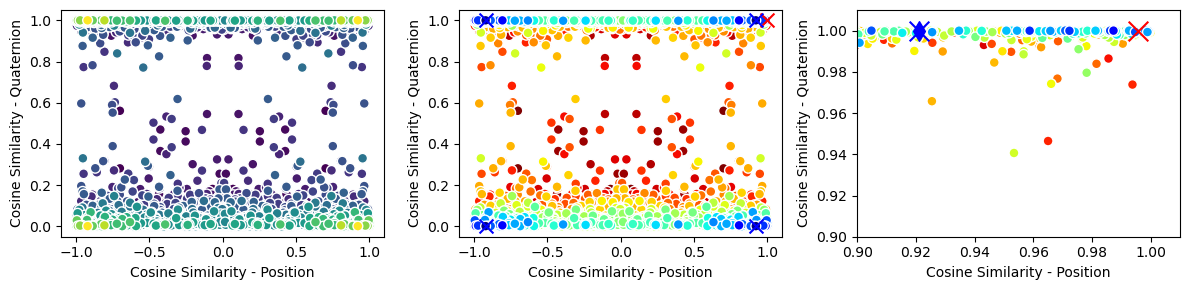

In [19]:

key = keysplit(key)
inds = random_choices(key, len(uvs0), (2_000, 8))


p_cv = infer_pose(uvs0, uvs1, cam_K, prob=.9999, threshold=1.0, max_iters=1000)

%timeit -n 1 -r 1 jax.block_until_ready(exp3(inds, 10.));

Es, ps, scores, errs = exp3(inds, jnp.array(.1))
ps = ps.reshape(-1)
scores = scores.reshape(-1) 
errs = errs.reshape(-1)
# perm = jnp.argsort(errs)[::-1]
perm = jnp.argsort(scores)

Es = Es[perm]
ps = ps[perm]
scores = scores[perm]
errs = errs[perm]





print("Score", scores.min(), scores.max())
print("Err", errs.min(), errs.max())
print(xq_cos(p_cv, p_true))
print(xq_cos(ps[-4:], p_true))

metric = xq_cos

fig, axs = plt.subplots(1,3,figsize=(12,3))



ax = axs[0]
ax.set_xlabel("Cosine Similarity - Position")
ax.set_ylabel("Cosine Similarity - Quaternion")
# ax.set_xlim(0.5, 1.02)
# ax.set_ylim(0.8, 1.02)
# ax.scatter(1,1, s=100, c="r", marker="s", alpha=0.5)
ax.scatter(*metric(ps, p_true), s=50, c=scores, alpha=1., cmap="viridis", edgecolor="w")
# ax.scatter(*metric(ps, p_true), s=10, c=-errs, alpha=1., cmap="viridis")
# ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")



k = 5*12
i_max_score = jnp.argmax(scores)
i_min_err_k = jnp.argmin(errs[-k:])
i_min_err = jnp.argmin(errs[:])


ax = axs[1]
ax.set_xlabel("Cosine Similarity - Position")
ax.set_ylabel("Cosine Similarity - Quaternion")
# ax.set_xlim(0.5, 1.02)
# ax.set_ylim(0.8, 1.02)
# ax.scatter(1,1, s=100, c="r", marker="s", alpha=0.5)
# ax.scatter(*metric(ps, p_true), s=10, c=scores, alpha=1., cmap="viridis")
ax.scatter(*metric(ps, p_true), s=50, c=errs, alpha=1., cmap="jet", edgecolor="w")
# ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")
ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")
# ax.scatter(*metric(pose_variations(ps[-k:][i_min_err_k]), p_true), s=100, c="b", marker="x")
ax.scatter(*metric(pose_variations(ps[i_min_err]), p_true), s=100, c="b", marker="x")


ax = axs[2]
ax.set_xlabel("Cosine Similarity - Position")
ax.set_ylabel("Cosine Similarity - Quaternion")
ax.set_xlim(0.9, 1.01)
ax.set_ylim(0.9, 1.01)



# i_min_err = jnp.argmax(scores[-k:])
# ax.scatter(1,1, s=200, c="lightgreen", marker="s", alpha=0.1)
ax.scatter(*metric(ps[:], p_true), s=50, c=errs[:], marker="o", cmap="jet", edgecolor="w", alpha=1.);
ax.scatter(*metric(p_cv, p_true), s=200, c="r", marker="x")
ax.scatter(*metric(pose_variations(ps[-k:][i_min_err_k]), p_true), s=100, c="b", marker="d")
ax.scatter(*metric(pose_variations(ps[i_min_err]), p_true), s=200, c="b", marker="x")
# ax.scatter(*metric(pose_variations(ps[i_max_score]), p_true), s=100, c="b", marker="d")

fig.tight_layout()

In [532]:
fi = jax.jit(find_best_chirality)

In [537]:
find_best_chirality(pose_variations(ps[i_min_err]), ys0, ys1)[0];
p1 = find_best_chirality(pose_variations(ps[i_min_err]), ys0, ys1)[0]

%timeit -n 1 -r 1 jax.block_until_ready(fi(pose_variations(ps[i_min_err]), ys0, ys1)[0]);


xq_cos(p1, p_true)

110 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


(Array(0.9991263, dtype=float32), Array(0.99994993, dtype=float32))

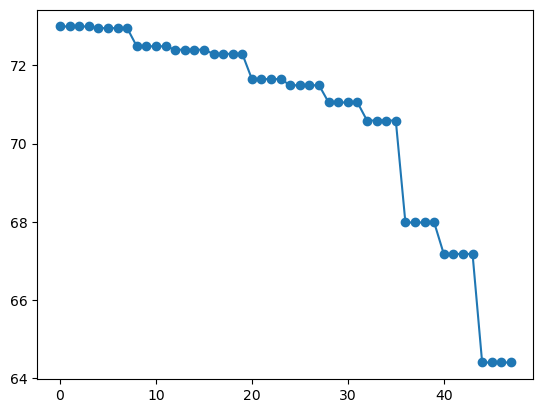

In [343]:
plt.plot(errs[-k:], marker="o")

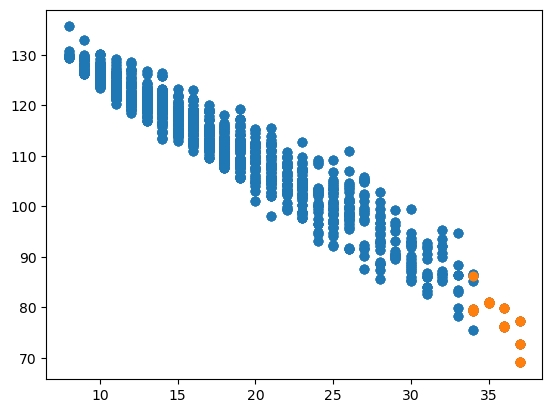

In [294]:
plt.scatter(scores, errs)
plt.scatter(scores[-k:], errs[-k:])

In [306]:
def _translation_scores(x, q):
    E = essential_from_pose(Pose(x, q))
    inliers = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv) < 5.1
    score = jnp.sum(inliers)
    return score

translation_scores = jax.jit(jax.vmap(_translation_scores, (0, None)))



def _scorer(p):
    E = essential_from_pose(p)
    errs = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv)
    errs = jnp.clip(errs, 0.0, 4.5)

    return -errs

scorer = jax.jit(jax.vmap(_scorer))

69.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


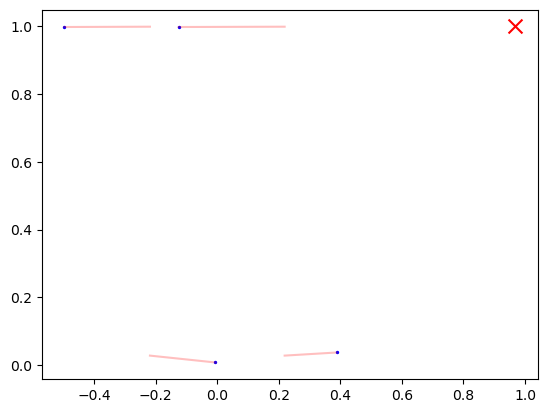

In [311]:
def improve_candidates(key, cands):
    improved = []
    for p in cands:


        # dx = xq_cos(p, p_true)

        key, keys = keysplit(key, 1, 1_000_000)
        qs = vmap_uniform_pose(keys, p, .8, 0.05)
        scores = scorer(qs)
        p_  = qs[jnp.argmax(scores)]

        improved.append(p_)

    return Pose.stack_poses(improved)



cands = pose_variations(ps[-k:][i_min_err])
# cands = ps[20:]
key = keysplit(key)
improved = improve_candidates(key, cands)
%timeit -n 1 -r 1 improve_candidates(key, cands);




plt.scatter(*xq_cos(p_cv, p_true), c="r", s=100, marker="x")
for p,p_ in zip(cands, improved):
    dx = xq_cos(p, p_true)
    dx_ = xq_cos(p_, p_true)
    plt.scatter(dx_[0], dx_[1], c="b", s=2)
    plt.plot([dx[0], dx_[0]], [dx[1], dx_[1]], c="r", alpha=0.25)

In [373]:
q0 = ps[-4 + 1].quat

key, keys = keysplit(key, 1, 100_000)
qs = vmap_uniform_pose(keys, Pose(jnp.zeros(3), q0), 1., 0.1)



scores = scorer(qs)

%timeit -n 1 -r 1 jax.block_until_ready(scorer(qs));


p = qs[jnp.argmax(scores)]

print(xq_cos(p, p_true))
print(xq_cos(Pose(-p.pos, p.quat), p_true))
# print(xq_cos(Pose(-x, q), p_true))


3.03 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
(Array(0.9473765, dtype=float32), Array(0.9798653, dtype=float32))
(Array(-0.9473765, dtype=float32), Array(0.9798653, dtype=float32))


In [ ]:

key = keysplit(key)
inds = random_choices(key, len(uvs0), (2_000, 8))


p_cv = infer_pose_using_cv(uvs0, uvs1, cam_K, prob=.9999, threshold=1.0, max_iters=1000)

%timeit -n 1 -r 1 jax.block_until_ready(exp2(inds, 5.1));

Es, ps, scores = exp2(inds, jnp.array(1.))
ps = ps.reshape(-1)
scores = scores.reshape(-1) 
perm = jnp.argsort(scores)

Es = Es[perm]
ps = ps[perm]
scores = scores[perm]

qs = Pose.stack_poses([
    recover_pose_cv(E, uvs0, uvs1, cam_K) for E in Es[-20:]
])


print(xq_cos(p_cv, p_true))
print(xq_cos(ps[-4:], p_true))

metric = xq_cos

fig, axs = plt.subplots(1,2,figsize=(10,3))

ax = axs[0]
# ax.set_xlim(0.5, 1.02)
# ax.set_ylim(0.75, 1.02)
ax.scatter(1,1, s=100, c="r", marker="s", alpha=0.5)
ax.scatter(*metric(ps, p_true), s=10, c=scores, alpha=1., cmap="viridis")
# ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")

ax = axs[1]
# ax.set_xlim(0.9, 1.02)
ax.set_ylim(0.9, 1.02)


k = 100
ax.scatter(1,1, s=200, c="lightgreen", marker="s", alpha=0.5)
ax.scatter(*metric(p_cv, p_true), s=100, c="r", marker="x")
ax.scatter(*metric(ps[-k:], p_true), s=20, c=scores[-k:], marker=".");

In [311]:
import plotly.graph_objs as go
import numpy as np

# Assuming xs and cs are defined as numpy arrays
# xs should be of shape (N, 3)
# cs should be of shape (N,)

# Example data (replace with your actual data)
from jax.scipy.spatial.transform import Rotation as Rot



k = 200
euler_true = p_true.rot.as_euler("xyz")
# xs = ps[-k:].rot.as_euler("xyz")
xs = ps[-k:].quat[:,:3]
# xs = xs/jnp.linalg.norm(xs, axis=1)[:,None]
# xs = ps[-k:].pos
cs = metric(ps[-k:], p_true)[1]
# cs = scores[-k:]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=xs[:, 0],  # X axis
    y=xs[:, 1],  # Y axis
    z=xs[:, 2],  # Z axis
    mode='markers',
    marker=dict(
        size=5,
        color=cs,  # Color based on cs array
        colorscale='jet',  # Color scale
        # opacity=0.8,
        cmin=0.98,
        cmax=1.0,
    )
)])

# Set the layout for the plot
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    margin=dict(l=0, r=0, b=0, t=0)  # Tight layout
)

# Display the plot
fig.show()

(array([ 304.,  636.,  864., 1084., 1276., 1200., 1176., 1160., 1292.,
        1108., 1012.,  828.,  768.,  584.,  736.,  520.,  496.,  480.,
         416.,  380.,  348.,  272.,  324.,  252.,  216.,  280.,  244.,
         192.,  192.,  180.,  116.,  184.,   96.,  136.,  100.,   52.,
          96.,   52.,   84.,   20.,   32.,   40.,   36.,   16.,   16.,
          20.,   16.,   36.,    8.,   16.,    4.,    4.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59

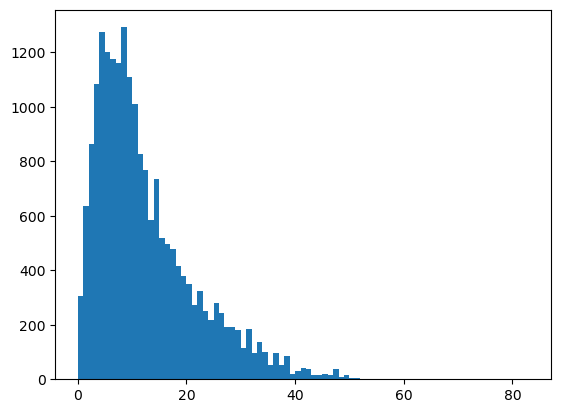

In [210]:
plt.hist(scores, bins=jnp.arange(len(uvs0)))

In [211]:

def _translation_scores(x, q):
    E = essential_from_pose(Pose(x, q))
    inliers = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv) < 5.1
    score = jnp.sum(inliers)
    return score

translation_scores = jax.jit(jax.vmap(_translation_scores, (0, None)))



def _scorer(p):
    E = essential_from_pose(p)
    inliers = epipolar_image_distances(E, ys0, ys1, cam_K, cam_K_inv) < 5.1
    score = jnp.sum(inliers)
    return score

scorer = jax.jit(jax.vmap(_scorer))

In [212]:
# xs = ps[-k:].quat[:,:3]

k = 5_000
xs = ps[-k:].rot.as_euler("xyz")
h, e = jax.numpy.histogramdd(xs, bins=[jnp.linspace(-jnp.pi*0.5, jnp.pi*0.5, 200)]*3)
e = jnp.stack(jnp.meshgrid(*e))
# h.shape
# quats = Rot.from_euler("xyz", xs).as_quat()

# plt.scatter(*metric(ps[-k:], p_true), s=20, c=scores[-k:], marker=".");
# qs.shape

jnp.argmax(h)

i = jnp.unravel_index(jnp.argmax(h), h.shape)
# e[:, i[0], i[1], i[2]]
e[:,*i]

xq_cos(Pose(jnp.ones(3), Rot.from_euler("xyz", e[:,*i]).as_quat()), p_true)
# xq_cos(Pose(jnp.ones(3), Rot.from_euler("xyz", e[:, i[0]+1, i[1]+1, i[2]+1]).as_quat()), p_true)



q0 = Rot.from_euler("xyz", e[:,*i]).as_quat()


print(xq_cos(Pose(jnp.zeros(3), q0), p_true))

(Array(nan, dtype=float32), Array(0.9809245, dtype=float32))


(Array(0.5536579, dtype=float32), Array(0.9806936, dtype=float32))
(Array(-0.5536579, dtype=float32), Array(0.9806936, dtype=float32))


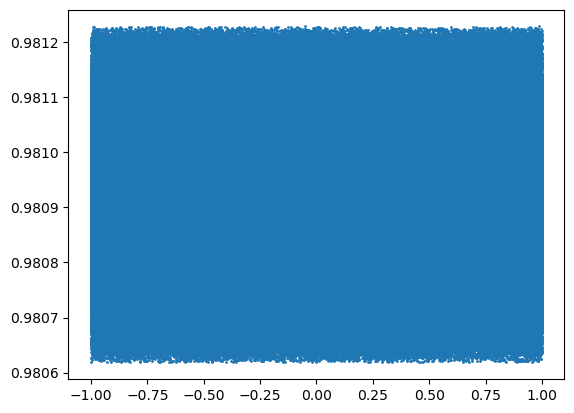

In [213]:



key, keys = keysplit(key, 1, 1_000_000)
qs = vmap_uniform_pose(keys, Pose(jnp.zeros(3), q0), 1., 0.001)


scores = scorer(qs)
p = qs[jnp.argmax(scores)]

# key = keysplit(key)
# xs = jax.random.normal(key, (1_000_000,3))
# xs = xs / jnp.linalg.norm(xs, axis=-1, keepdims=True)

# xs = xs.at[0].set(p_true.pos)

# print(xs.shape)



# %timeit -n 1 -r 1 jax.block_until_ready(translation_scores(xs, q));


# scores = translation_scores(xs, p_true.quat)
# x = xs[jnp.argmax(scores)]
# x = xs[0]

# print(scores[:10])


# print(xq_cos(Pose.id(), p_true))
# print(xq_cos(p_cv, p_true))
# print(xq_cos(Pose(x, q), p_true))
# print(xq_cos(Pose(-x, q), p_true))
# print(xq_cos(Pose(p_true.pos*0.1, q), p_true))


# plt.plot(scores[:40])

print(xq_cos(p, p_true))
print(xq_cos(Pose(-p.pos, p.quat), p_true))
# print(xq_cos(Pose(-x, q), p_true))

plt.scatter(*xq_cos(qs, p_true), s=1)

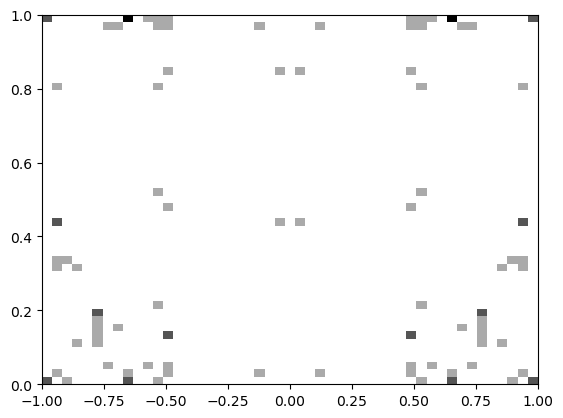

In [31]:
plt.hist2d(*metric(ps[-100:], p_true), 
           bins=[
               np.linspace(-1.,1.,50), 
               np.linspace(0.,1.,50)
            ], 
            cmap="binary");

# plt.scatter(*metric(p_cv, p_true), c="r", marker="x", clip_on=False);

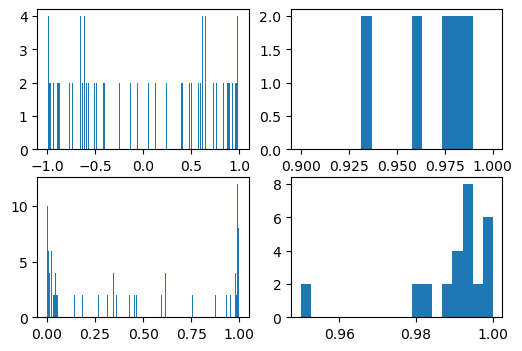

In [34]:
k = 100

fig, axs = plt.subplots(2,2,figsize=(6,4))
axs[0,0].hist(metric(ps[-k:], p_true)[0], bins=np.linspace(-1,1.,200));
axs[1,0].hist(metric(ps[-k:], p_true)[1], bins=np.linspace(0, 1.,200));

axs[0,1].hist(metric(ps[-k:], p_true)[0], bins=np.linspace(.9,1.,20));
axs[1,1].hist(metric(ps[-k:], p_true)[1], bins=np.linspace(.95,1.,20));

6.79 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


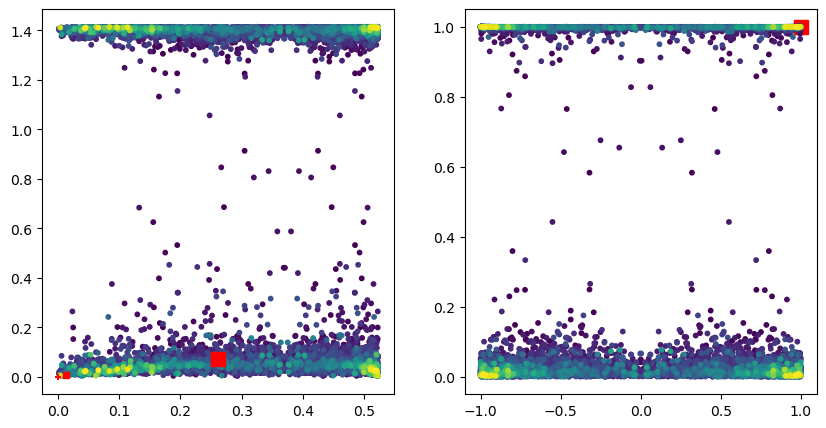

In [148]:

key = keysplit(key)
inds = random_choices(key, len(uvs0), (2500, 8))


p_cv = infer_pose_using_cv(uvs0, uvs1, cam_K, prob=.999999, threshold=1.0, max_iters=1000)
p_cv = rescale_pose(p_cv, p_true)

p_id = rescale_pose(Pose.id(), p_true)

%timeit -n 1 -r 1 jax.block_until_ready(exp2(inds));
ps2, errs = exp2(inds)
ps2 = ps2.reshape(-1)
errs = errs.reshape(-1) 
perm = jnp.argsort(errs)[:]
ps2 = ps2[perm]
errs = errs[perm]
ps2 = rescale_poses(ps2, p_true)



fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].scatter(*jax.vmap(xq_dist, (0, None))(ps2, p_true), s=10, c=errs, alpha=1., cmap="viridis")

axs[0].scatter(0,0, s=20, c="r", marker="+")
axs[0].scatter(*xq_dist(p_cv, p_true), s=20, c="r", marker="s")
axs[0].scatter(*xq_dist(Pose.id(), p_true), s=100, c="r", marker="s")


axs[1].scatter(1,1, s=100, c="r", marker="s")
axs[1].scatter(*jax.vmap(xq_cos, (0, None))(ps2, p_true), s=10, c=errs, alpha=1., cmap="viridis")